In [1]:
# %% ####################################################
rm(list = ls())
library(LalRUtils)

In [2]:
LalRUtils::libreq(tidyverse, data.table, patchwork, stargazer2, scales)
theme_set(lal_plot_theme())
options(repr.plot.width=14, repr.plot.height=9)

     wants        loaded
[1,] "tidyverse"  TRUE  
[2,] "data.table" TRUE  
[3,] "patchwork"  TRUE  
[4,] "stargazer2" TRUE  
[5,] "scales"     TRUE  


In [3]:
## Source: NY Times COVID-19 data repo: https://github.com/nytimes/covid-19-data
nytc = fread('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
nytc[, `:=` (date = as.Date(date), fips = sprintf('%05d', fips))]

In [4]:
# 2016 election data ------------------------------------------------------

## Counties (Source: https://github.com/tonmcg/US_County_Level_Election_Results_08-16)
counties_res = fread('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2016_US_County_Level_Presidential_Results.csv')
us2016_counties = counties_res[, `:=` (fips = sprintf('%05d', combined_fips),
                          result_county = fifelse(per_dem > per_gop, 'Clinton won', 'Trump won'))] %>%
  .[, .(fips, state_abbr, result_county)]

counties_res %>% glimpse

us2016_counties %>% glimpse

Rows: 3,141
Columns: 13
$ V1             <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …
$ votes_dem      <dbl> 93003, 93003, 93003, 93003, 93003, 93003, 93003, 93003…
$ votes_gop      <dbl> 130413, 130413, 130413, 130413, 130413, 130413, 130413…
$ total_votes    <dbl> 246588, 246588, 246588, 246588, 246588, 246588, 246588…
$ per_dem        <dbl> 0.3772, 0.3772, 0.3772, 0.3772, 0.3772, 0.3772, 0.3772…
$ per_gop        <dbl> 0.5289, 0.5289, 0.5289, 0.5289, 0.5289, 0.5289, 0.5289…
$ diff           <chr> "37,410", "37,410", "37,410", "37,410", "37,410", "37,…
$ per_point_diff <chr> "15.17%", "15.17%", "15.17%", "15.17%", "15.17%", "15.…
$ state_abbr     <chr> "AK", "AK", "AK", "AK", "AK", "AK", "AK", "AK", "AK", …
$ county_name    <chr> "Alaska", "Alaska", "Alaska", "Alaska", "Alaska", "Ala…
$ combined_fips  <int> 2013, 2016, 2020, 2050, 2060, 2068, 2070, 2090, 2100, …
$ fips           <chr> "02013", "02016", "02020", "02050", "02060", "02068", …
$ result_county  <chr> "Trum

In [5]:
## States
us2016_states = fread('https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Election16.csv')
us2016_states =
  us2016_states[, result_state := fifelse(TrumpWin==1, 'Trump won', 'Clinton won')] %>%
  .[, .(state_abbr = Abr, result_state)]

In [6]:
## Merge and melt (reshape longer)
us2016 =
  us2016_counties[us2016_states, on='state_abbr'] %>%
  melt(id = c('fips', 'state_abbr'), variable.name = 'geo', value.name = 'result') %>%
  .[, geo := gsub('result_', '', geo)]

# Merge -------------------------------------------------------------------
us = nytc[us2016, on = 'fips', allow.cartesian = TRUE] %>%
  .[!is.na(date),
    lapply(.SD, sum, na.rm = TRUE), .SDcols = c('cases', 'deaths'),
    by = .(date, geo, result)]

us %>% glimpse

Rows: 1,238
Columns: 5
$ date   <date> 2020-03-24, 2020-03-25, 2020-03-26, 2020-03-27, 2020-03-28, 2…
$ geo    <chr> "county", "county", "county", "county", "county", "county", "c…
$ result <chr> "Trump won", "Trump won", "Trump won", "Trump won", "Trump won…
$ cases  <int> 9528, 11979, 15278, 19066, 23094, 27270, 32027, 37726, 44048, …
$ deaths <int> 128, 176, 234, 322, 409, 463, 562, 714, 915, 1147, 1343, 1677,…


In [7]:
## Get daily counts and percentages
setorder(us, geo, result, date)
us[ , ':=' (daily_cases = cases - shift(cases, 1, 'lag'),
            daily_deaths = deaths - shift(deaths, 1, 'lag')),
    by = .(geo, result)] %>%
  .[, ':=' (daily_cases_perc = daily_cases/sum(daily_cases),
            daily_deaths_perc = daily_deaths/sum(daily_deaths)),
    by = .(geo, date)]

## Some labeling sugar to match the WaPo graphic
us$geo = factor(us$geo, levels = c('state', 'county'), labels = c('States', 'Counties'))

Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”


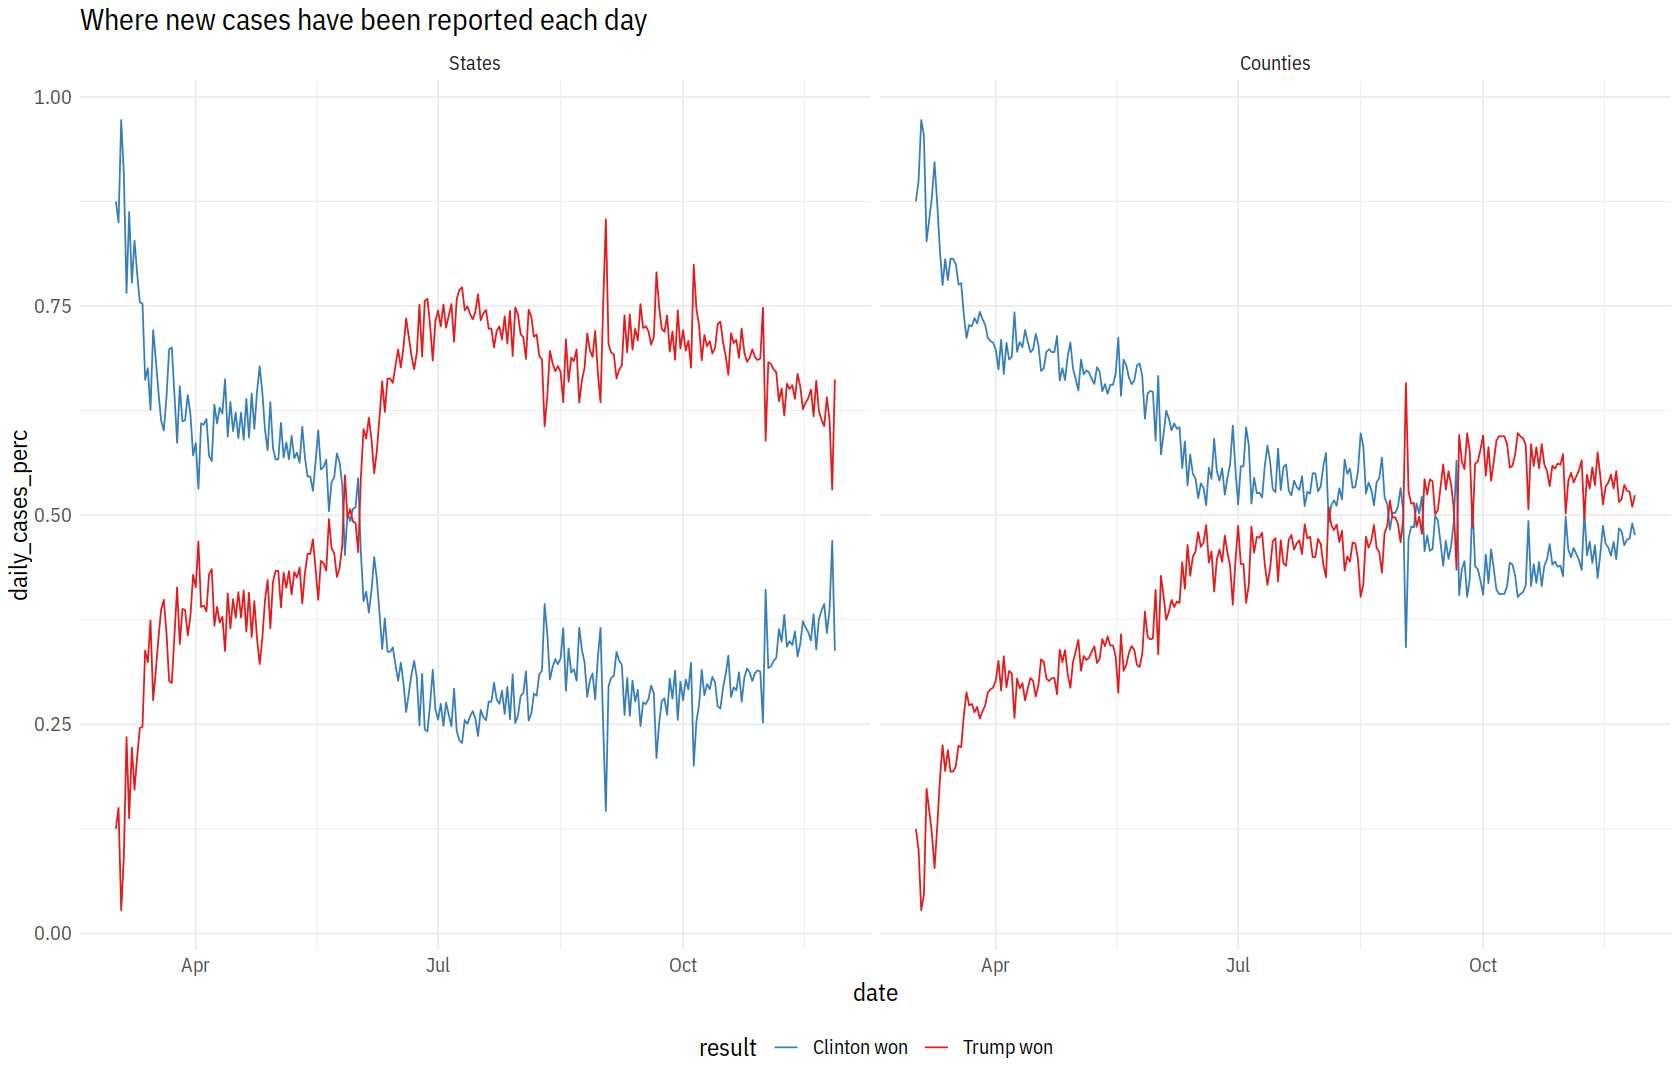

In [8]:
## Cases
ggplot(us[date>'2020-03-01'], aes(date, daily_cases_perc, col = result)) +
  geom_line() +
  scale_color_brewer(palette = 'Set1', direction = -1) +
#   scale_y_percent(limits = c(0,1)) +
  labs(title = 'Where new cases have been reported each day') +
  facet_wrap(~ geo)

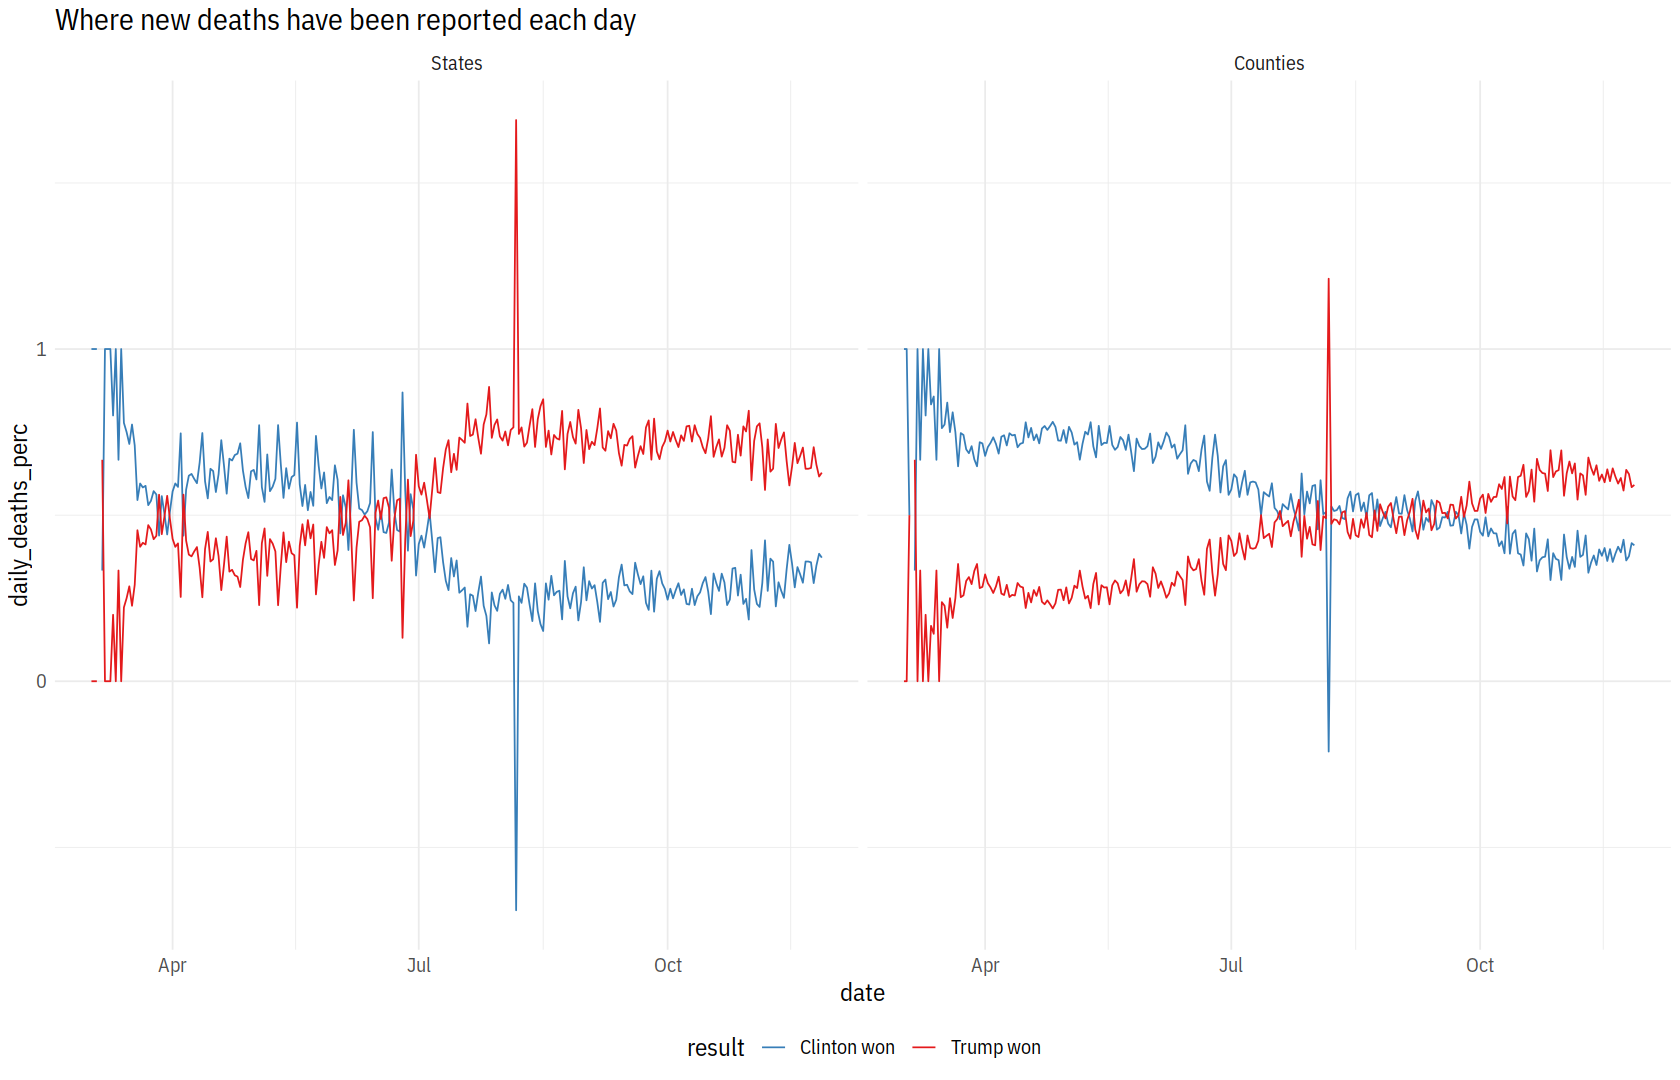

In [9]:
## Deaths
ggplot(us[date>'2020-03-01'], aes(date, daily_deaths_perc, col = result)) +
  geom_line() +
  scale_color_brewer(palette = 'Set1', direction = -1) +
#   scale_y_percent(limits = c(0,1)) +
  labs(title = 'Where new deaths have been reported each day') +
  facet_wrap(~ geo)

In [10]:
## New county by state data table
uscs =
  nytc[us2016_counties[us2016_states, on='state_abbr'], on = 'fips', allow.cartesian = TRUE] %>%
    .[!is.na(date),
      lapply(.SD, sum, na.rm = TRUE), .SDcols = c('cases', 'deaths'),
      by = .(date, result_state, result_county)]

## Get daily counts and percentages
setorder(uscs, result_state, result_county, date)
uscs[ , ':=' (daily_cases = cases - shift(cases, 1, 'lag'),
              daily_deaths = deaths - shift(deaths, 1, 'lag')),
      by = .(result_state, result_county)] %>%
  .[, ':=' (daily_cases_perc = daily_cases/sum(daily_cases),
            daily_deaths_perc = daily_deaths/sum(daily_deaths)),
    by = .(result_state, date)]

## Some labeling sugar
uscs$result_state = factor(paste('States that', uscs$result_state))
uscs$result_county = factor(paste('Counties that', uscs$result_county))

Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(cases, 1, "lag"):
“NAs introduced by coercion”
Warning message in shift(deaths, 1, "lag"):
“NAs introduced by coercion”


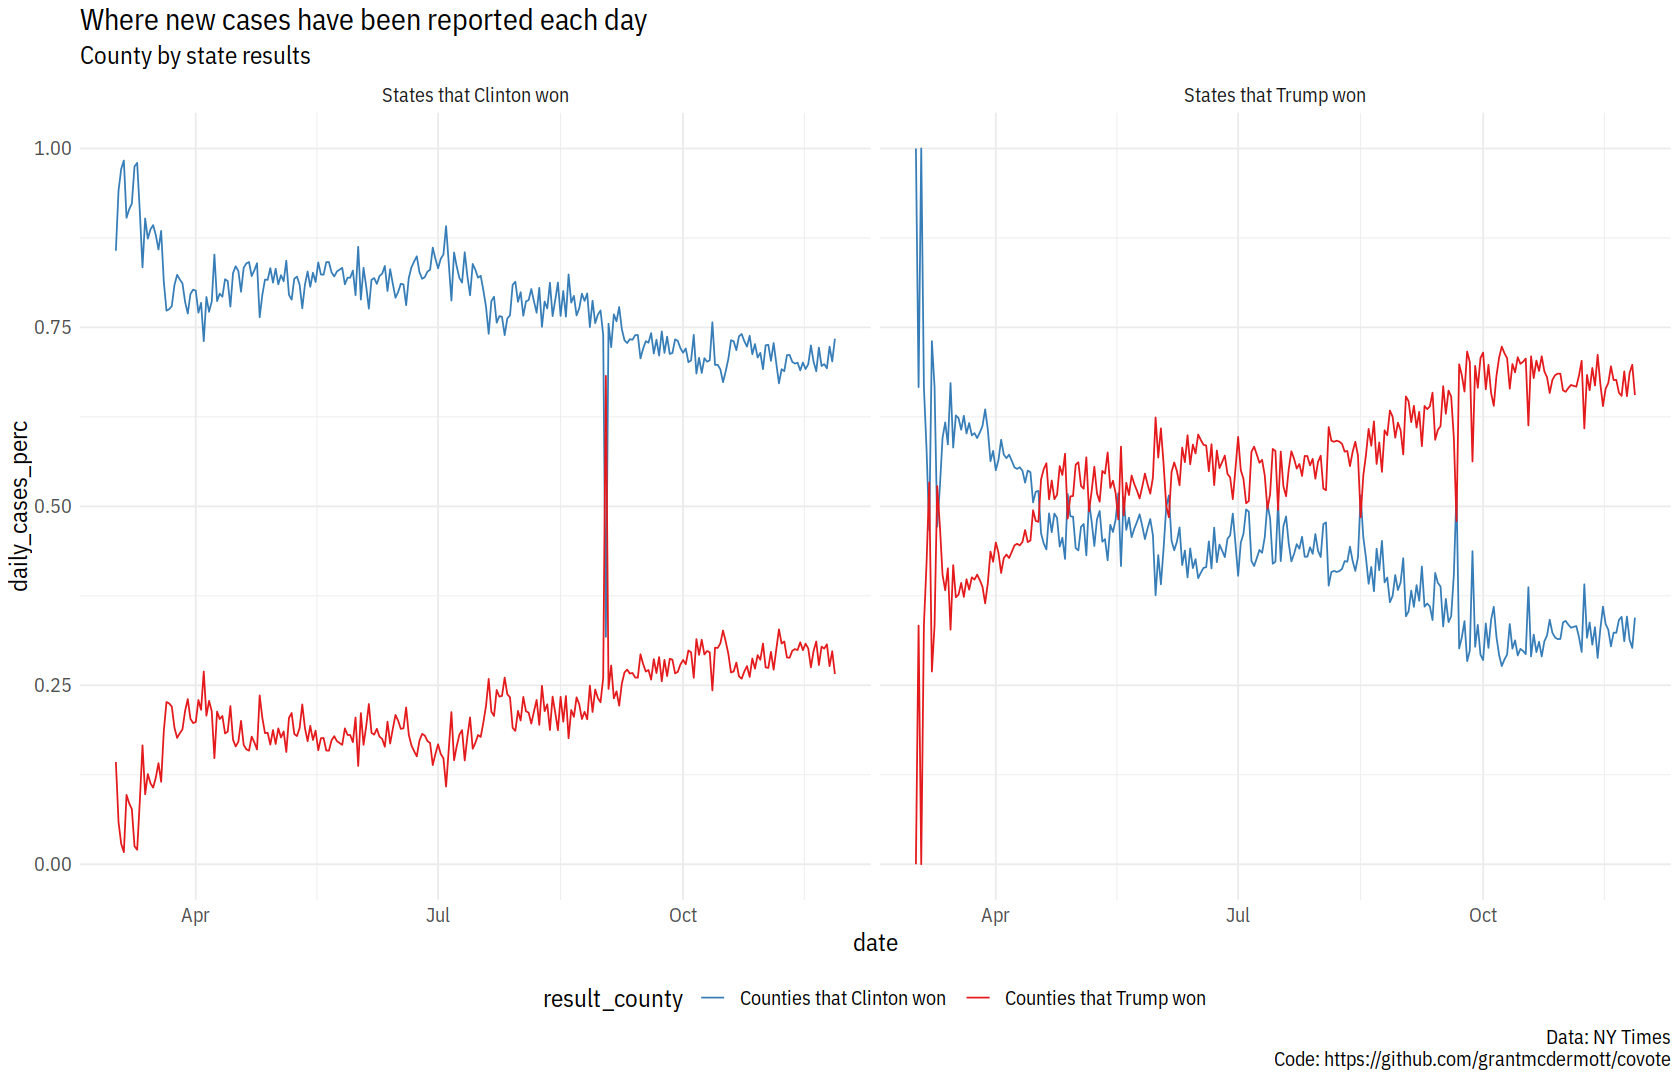

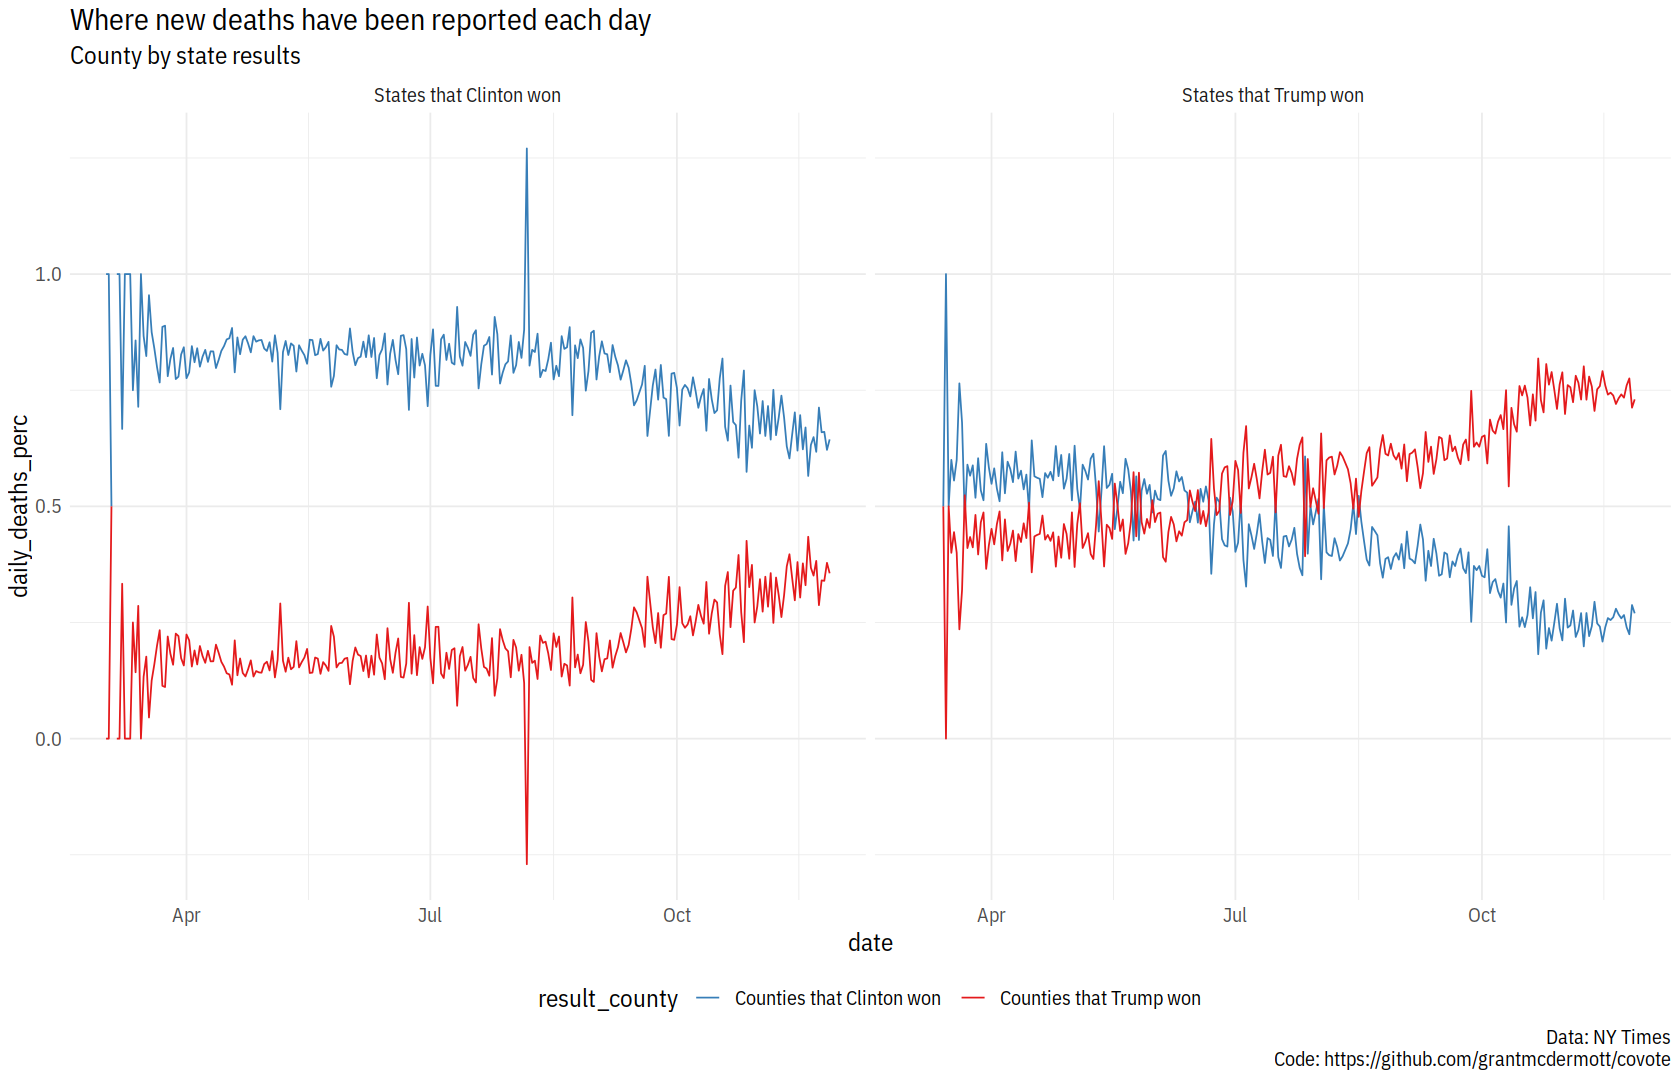

In [11]:
## Cases
ggplot(uscs[date>'2020-03-01'], aes(date, daily_cases_perc, col = result_county)) +
  geom_line() +
  scale_color_brewer(palette = 'Set1', direction = -1) +
#   scale_y_percent(limits = c(0,1)) +__
  labs(title = 'Where new cases have been reported each day',
       subtitle = 'County by state results',
       caption = 'Data: NY Times\nCode: https://github.com/grantmcdermott/covote') +
  facet_wrap(~ result_state)


## Deaths
ggplot(uscs[date>'2020-03-01'], aes(date, daily_deaths_perc, col = result_county)) +
  geom_line() +
  scale_color_brewer(palette = 'Set1', direction = -1) +
#   scale_y_percent(limits = c(0,1)) +
  labs(title = 'Where new deaths have been reported each day',
       subtitle = 'County by state results',
       caption = 'Data: NY Times\nCode: https://github.com/grantmcdermott/covote') +
  facet_wrap(~ result_state)

#  2020 Election

In [13]:
# 2016 election data ------------------------------------------------------

## Counties (Source: https://github.com/tonmcg/US_County_Level_Election_Results_08-16)
counties_res = fread('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv')

counties_res %>% glimpse

# us2020_counties = counties_res[, `:=` (fips = sprintf('%05d', combined_fips),
#                           result_county = fifelse(per_dem > per_gop, 'Biden won', 'Trump won'))] %>%
#   .[, .(fips, state_abbr, result_county)]
# us2016_counties %>% glimpse

Rows: 3,152
Columns: 10
$ state_name     <chr> "Alabama", "Alabama", "Alabama", "Alabama", "Alabama",…
$ county_fips    <int> 1001, 1003, 1005, 1007, 1009, 1011, 1013, 1015, 1017, …
$ county_name    <chr> "Autauga County", "Baldwin County", "Barbour County", …
$ votes_gop      <int> 19838, 83544, 5622, 7525, 24711, 1146, 5458, 35101, 87…
$ votes_dem      <int> 7503, 24578, 4816, 1986, 2640, 3446, 3965, 15216, 6365…
$ total_votes    <int> 27770, 109679, 10518, 9595, 27588, 4613, 9488, 50983, …
$ diff           <int> 12335, 58966, 806, 5539, 22071, -2300, 1493, 19885, 23…
$ per_gop        <dbl> 0.7144, 0.7617, 0.5345, 0.7843, 0.8957, 0.2484, 0.5753…
$ per_dem        <dbl> 0.27018, 0.22409, 0.45788, 0.20698, 0.09569, 0.74702, …
$ per_point_diff <dbl> 0.44418, 0.53762, 0.07663, 0.57728, 0.80002, -0.49859,…


In [19]:
state_lev_2020 = counties_res[, lapply(.SD, sum), by = state_name, .SDcols = c('votes_gop', 'votes_dem', 'total_votes')]
state_lev_2020[, dem_share := votes_dem / total_votes][, dem_win := fifelse(votes_dem > votes_gop, 1, 0)]
state_lev_2020

state_name,votes_gop,votes_dem,total_votes,dem_share,dem_win
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
Alabama,1441170,849624,2323282,0.3657,0
Alaska,189484,153129,356488,0.4295,0
Arizona,1661686,1672143,3385845,0.4939,1
Arkansas,760613,423916,1219014,0.3478,0
California,5962975,11055577,17395590,0.6355,1
Colorado,1364467,1804184,3256633,0.5540,1
Connecticut,715291,1080680,1824317,0.5924,1
Delaware,200603,296268,504010,0.5878,1
District of Columbia,18586,317323,344356,0.9215,1
